##### Κρικέλης Λάμπρος 
ΑΜ: 01852

# Project For the Subject Computetional Vision 

## Spatial Image Identification 

### Generally 

There is a data set with 134 pair of retinal images from the same eye and the same pateint (https://projects.ics.forth.gr/cvrl/fire/) 

#### Steps to fulfil the project
Select only 10 pairs and do the below actions. 
1. Read the .jpg files.
2. Project the edges of the 1st image onto the 2nd.
3. Use the appropriate .txt files from the “Ground Truth” directory to read the pairs of homologous points
4. Compute the affine geometric transformation matrix required to identify (as far as possible) the selected homologous points.
5. Apply the transformation to the one image and use a visualization technique to demonstrate the accuracy of the transformation.
6. Use the correlation coefficient and the mutual information to quantify the matching of the 2 images, before and after the geometric transformation.

Please Complite the table below: 
1. You can find the table in this directory  under the name OutputMatrix.xlsx 
2. The directory OutPutsPerPear contains all the images and the information requested 


Please insert the FIRE FOLDER under this dir to run the below notebook

In [27]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np
import cv2
from PIL import Image 
import numpy.ma as ma
from sklearn.metrics import mutual_info_score
import SimpleITK as sitk
import time

In [28]:
# We use this variable to iterate through each pear we want
iteration = 1

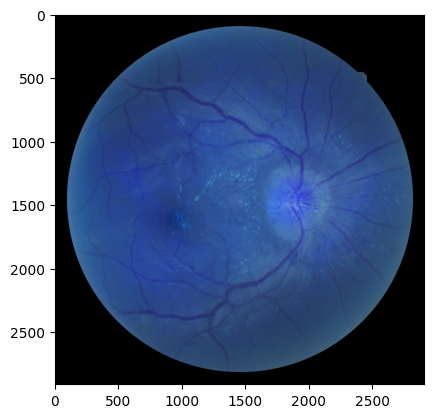

In [29]:
'''Below We import and visualize the image'''

IMG_PATH1_1 = os.path.join('FIRE','Images',f'A0{iteration}_1.jpg')
image1_1 = cv2.imread(IMG_PATH1_1)
plt.imshow(image1_1)

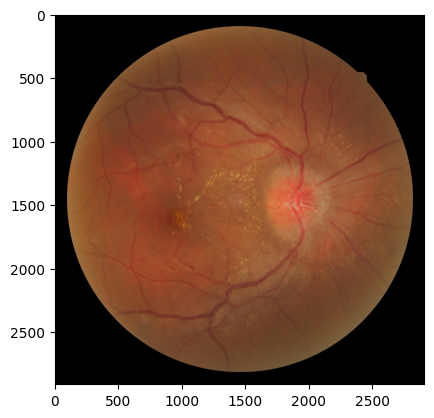

In [30]:
# Convert the image to rgb
image1_1=cv2.cvtColor(image1_1, cv2.COLOR_BGR2RGB)
plt.imshow(image1_1)

#### Here we will try to detect the edges of the image.
1. For the 1st step we will try to soften the image with the use of Gaussian bluer.
2. Then we are using the Sobel edge detection matrix  to ditect the edges both on X and Y axis !!! This is important. Otherwise we would have the wronge output
3. Then After we find the x and the y edges of the image we combine them into one image with 50% overly each image.
4. Visualize the findings 

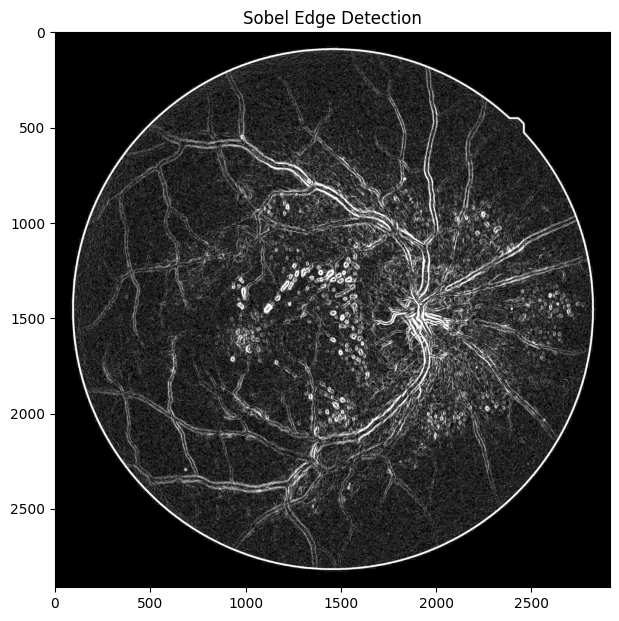

In [31]:
gray_image = cv2.cvtColor(image1_1, cv2.COLOR_BGR2GRAY)


""" Gaussian Blur with a mask of to smooth the image
    At this blur I figured I should use a bigger table due to the fact that We dont have a lot of variaty of 
    values in our image therefore we couldn't see any different in our blured image
"""

blurred_image = cv2.GaussianBlur(gray_image, (11,11), 0)

""" Apply Sobel edge horizontal and vertical edge detection so we can find the edges 
"""
sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)  # Sobel X (horizontal)
sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)  # Sobel Y (vertical)

# Combine both Sobel filters 50-50 
sobel_combined = cv2.sqrt(sobelx**2 + sobely**2)

# Convert back to (0-255) scale for displaying
sobel_combined = cv2.convertScaleAbs(sobel_combined)

# Plot the original image and edge detection results
plt.figure(figsize=(12, 6))
# Visualize Sobel edge detection 
plt.subplot(1, 2, 1)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Edge Detection')

plt.tight_layout()
plt.show()

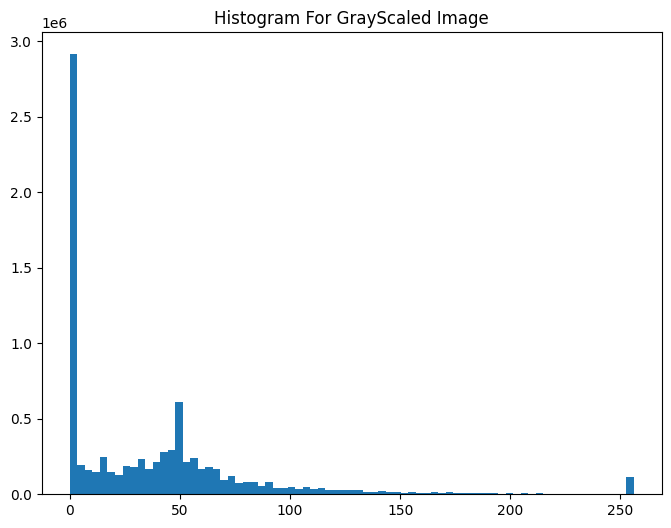

In [32]:
''' Show the histogram
With the scope of seeing where should the threshold for Otsu algorithm be. 
'''
plt.figure(figsize=(8, 6))
plt.hist(sobel_combined.flatten(),75,[0,256])
plt.title("Histogram For GrayScaled Image")
plt.show()

Optimal Threshold Value (Otsu's method): 82.0


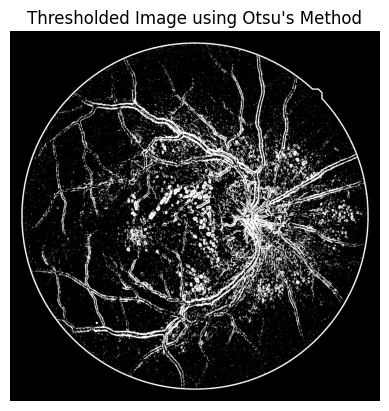

In [33]:
"""
    Here I am trying to get rid of the noise above.
    Using Otsu algorithm 
"""
optimal_threshold_value, otsu_thresholded_image = cv2.threshold(sobel_combined, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Optimal Threshold Value (Otsu's method): {optimal_threshold_value}")

# Display the threshold for the above image
plt.imshow(otsu_thresholded_image, cmap='gray')
plt.title('Thresholded Image using Otsu\'s Method')
plt.axis('off')
plt.show()

In [34]:
'''Below We import and visualize the image'''

IMG_PATH1_2 = os.path.join('FIRE','Images',f'A0{iteration}_2.jpg')
img2 = cv2.imread(IMG_PATH1_2)
img2.shape

(2912, 2912, 3)

(2912, 2912, 3)

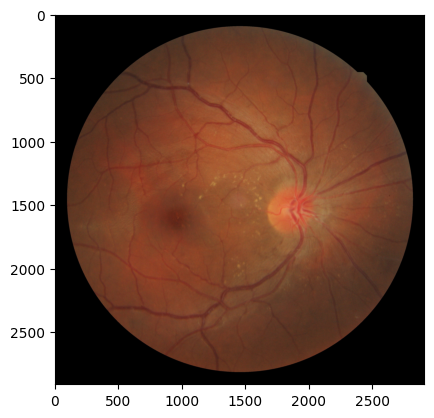

In [35]:
image1_2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(image1_2)
image1_2.shape

#### Below I am answeting the first task of  which is to make a fused image with the two pears 

In [36]:
alpha = 0.5 # merged factor for each image

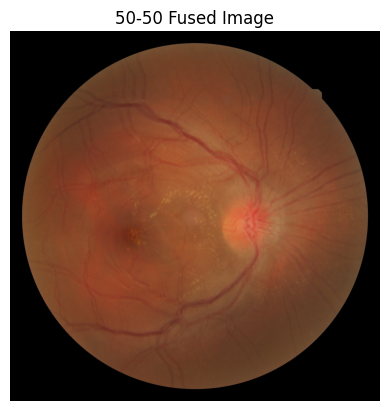

In [37]:
fused_image = cv2.addWeighted(image1_2,1 - alpha, image1_1, alpha, 0)

# Display the fused image
plt.imshow(fused_image)
plt.title('50-50 Fused Image')
plt.axis('off')
plt.show()

#### Below We will try to output the edges of the 1st image into the 2nd pear. 

1. We need to use a mask to "hold" temporarily the values of the edged detected image.
2. Second we need that mask to be on the same space (RGB on that case) as the image that we are trying to merge it with. 
3. We are merging the two images with a 50-50 ratio again.

In [38]:
mask = otsu_thresholded_image.astype(np.uint8)
overlay = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
combined = cv2.addWeighted(image1_2, 1 - alpha, overlay, alpha, 0)

Text(0.5, 1.0, 'Combined the edges displayed on Image 2')

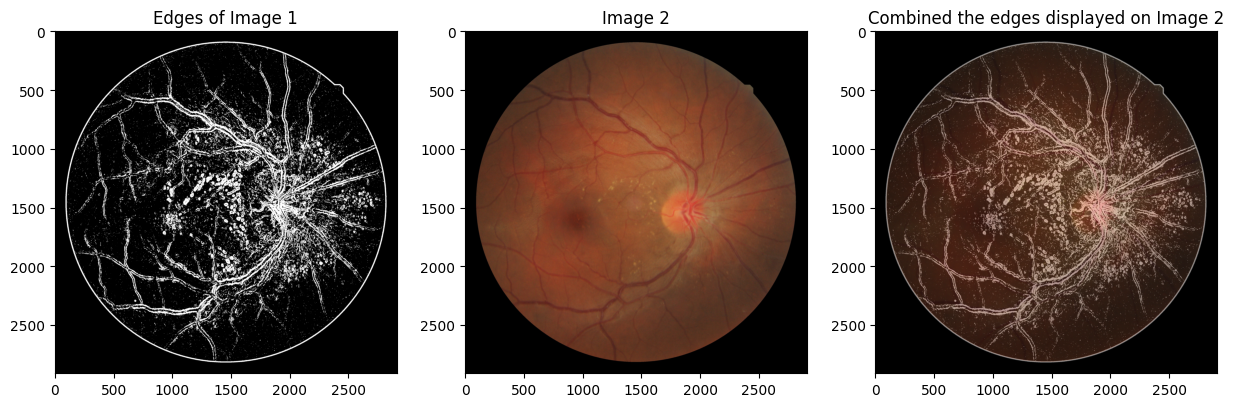

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(otsu_thresholded_image, cmap='gray')
axs[0].set_title("Edges of Image 1")

axs[1].imshow(image1_2)
axs[1].set_title("Image 2")

axs[2].imshow(combined)
axs[2].set_title("Combined the edges displayed on Image 2")

### Now We have to use the respectively points based on the images that we chose.

In [40]:
'''Below I am importing the instracted control points
We are trying to read the points line by line  
'''
POINTS_PATH1_1 = os.path.join('FIRE','Ground Truth',f'control_points_A0{iteration}_1_2.txt')

points = []

with open(POINTS_PATH1_1) as f:
    for line in f:  #Line is a string
        #split the string on whitespace, return a list of numbers 
        # (as strings)
        numbers_str = line.split()
        #convert numbers to floats
        numbers_float = [float(x) for x in numbers_str]
        points.append(numbers_float)

homologous_points = np.array(points)

homologous_points.shape
homologous_points.shape[1]

4

In [41]:
"""
Bellow We are making a script to split the homologous points into two arrays on which We will perform the transformation.
"""
row_points = homologous_points.shape[0]
column_points = homologous_points.shape[1]

half_row_points = row_points // 2
half_column_points = column_points //2
print(f"{half_row_points}, {half_column_points}")

5, 2


In [42]:
'''
We handle the homologous points in order to create (x,y) values that can be handled by x,y axis of the image
'''
points_src = np.float32(homologous_points[:half_row_points,:half_column_points])
points_dst = np.float32(homologous_points[-half_row_points:,half_column_points:])
print(f"{points_src}, \n\n {points_dst}")

[[ 332.  872.]
 [ 370. 1897.]
 [1212. 2483.]
 [1761.  348.]
 [2384. 1912.]], 

 [[2556. 1198.]
 [1949. 1194.]
 [ 670. 1192.]
 [1944. 1460.]
 [1328. 1784.]]


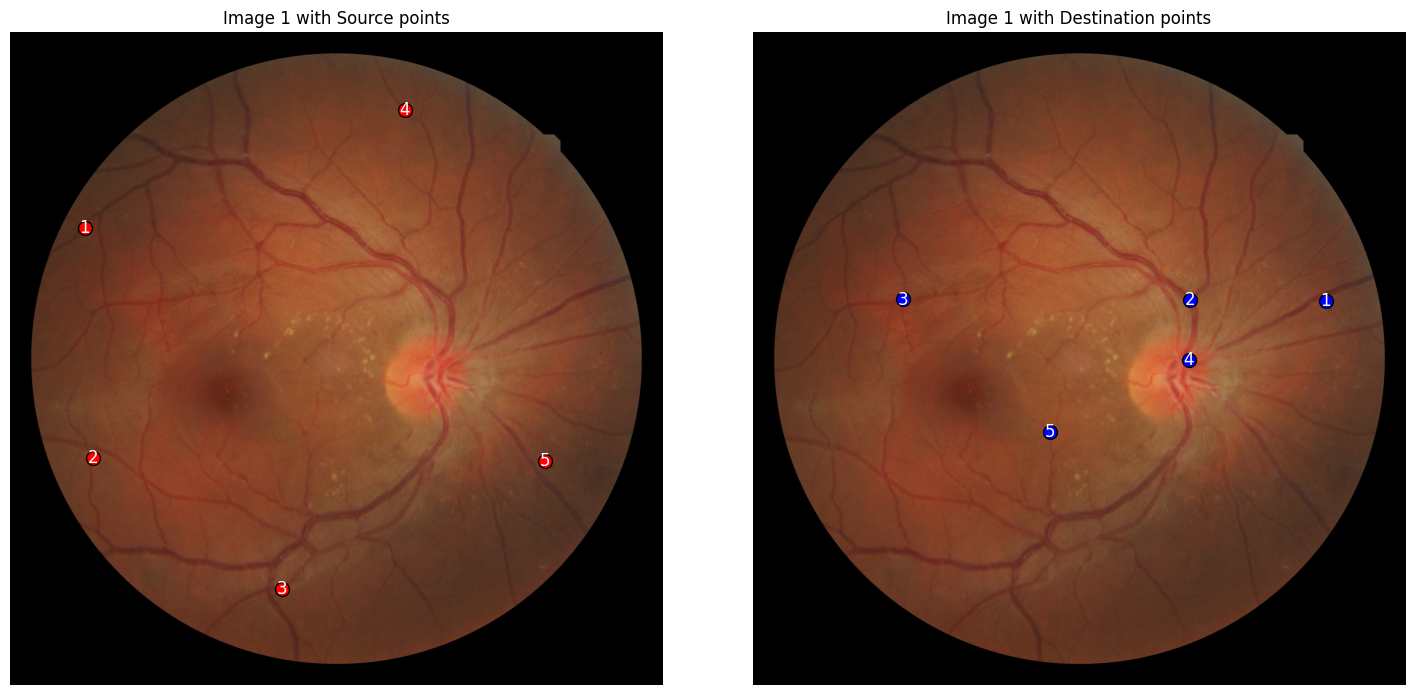

In [43]:
plt.figure(figsize=(15, 7))

# Source Points for Image 1
plt.subplot(1, 2, 1)
plt.imshow(image1_2)
plt.scatter(points_src[:, 0], points_src[:, 1], color='red', marker='o', s=100, edgecolor='black')

for i, (x, y) in enumerate(points_src):
    plt.text(x, y, f'{i+1}', color='white', fontsize=12, ha='center', va='center')

plt.title('Image 1 with Source points')
plt.axis('off')

# Image 2 for Destination Points 
plt.subplot(1, 2, 2)
plt.imshow(image1_2)
plt.scatter(points_dst[:, 0], points_dst[:, 1], color='blue', marker='o', s=100, edgecolor='black')

for i, (x, y) in enumerate(points_dst):
    plt.text(x, y, f'{i+1}', color='white', fontsize=12, ha='center', va='center')

plt.title('Image 1 with Destination points')
plt.axis('off')

plt.tight_layout()
plt.show()

In [44]:
'''Here I am creating the Affine transoframtion matrix based on the ground truth points'''
M, smth  = cv2.estimateAffinePartial2D(points_src, points_dst)
M_df = pd.DataFrame(M)
# M, smth  = cv2.estimateAffine2D(points_src, points_dst) 

print(f"Affine Transformation Matrix: \n {M}" )

Affine Transformation Matrix: 
 [[-3.60980019e-01 -4.68527885e-01  3.08440168e+03]
 [ 4.68527885e-01 -3.60980019e-01  1.35722332e+03]]


In [45]:
'''Now we are applying the created Affine Matrix to our images '''

transformed_image1_1 = cv2.warpAffine(image1_1, M, (image1_1.shape[1],image1_1.shape[0]))
transformed_image1_2 = cv2.warpAffine(image1_2, M, (image1_2.shape[1],image1_2.shape[0]))
"""
 NOTEEE!!! TO SHOW where our source point went we have to shift them base on the transformation they underwent
 Therefore we do the following transformations and to our source points from the M matrix that has been created by Affine Transormation. 
"""
transform_src = cv2.transform(np.array([points_src]),M)[0]


Text(0.5, 1.0, 'Image 2 After Transform')

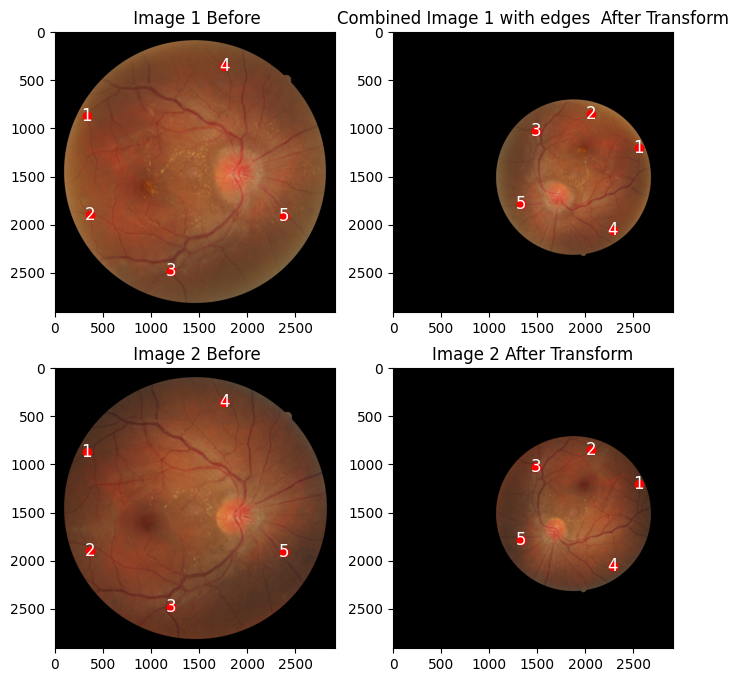

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(image1_1)
axs[0, 0].scatter(points_src[:, 0], points_src[:, 1],color='red', marker='o', label='Source Points')
axs[0, 0].set_title(" Image 1 Before")

# Add numbers to the points
for i, (x, y) in enumerate(points_src):
    axs[0, 0].text(x, y, f'{i + 1}', color='white', fontsize=12, ha='center', va='center')

axs[0,1].imshow(transformed_image1_1)
# axs[0,1].scatter(points_dst[:,0], points_dst[:,1], color='blue', marker='o', label='Destination Points')
axs[0,1].scatter(transform_src[:,0], transform_src[:,1], color='red', marker='o', label='Source Points')
axs[0,1].set_title("Combined Image 1 with edges  After Transform")
for i, (x, y) in enumerate(transform_src):
    axs[0, 1].text(x, y, f'{i + 1}', color='white', fontsize=12, ha='center', va='center')


axs[1,0].imshow(image1_2)
axs[1,0].scatter(points_src[:,0], points_src[:,1], color='red', marker='o', label='Source Points')
axs[1,0].set_title(" Image 2 Before")
for i, (x, y) in enumerate(points_src):
    axs[1, 0].text(x, y, f'{i + 1}', color='white', fontsize=12, ha='center', va='center')

axs[1,1].imshow(transformed_image1_2)
# axs[1,1].scatter(points_dst[:,0], points_dst[:,1], color='blue', marker='o', label='Destination Points')
axs[1,1].scatter(transform_src[:,0], transform_src[:,1], color='red', marker='o', label='Source Points')
for i, (x, y) in enumerate(transform_src):
    axs[1, 1].text(x, y, f'{i + 1}', color='white', fontsize=12, ha='center', va='center')

axs[1,1].set_title("Image 2 After Transform")

#### Here we will try to find out the CC and the Mutual information 

In [47]:
# Convert both images to grayscale
image1_1_gray = cv2.cvtColor(image1_1, cv2.COLOR_RGB2GRAY)
transformed_image1_1_gray = cv2.cvtColor(transformed_image1_1, cv2.COLOR_RGB2GRAY)

image1_2_gray = cv2.cvtColor(image1_2, cv2.COLOR_RGB2GRAY)
transformed_image1_2_gray = cv2.cvtColor(transformed_image1_2, cv2.COLOR_RGB2GRAY)

# Flatten the images
image1_1_flat = image1_1_gray.flatten()
transformed_image1_1_flat = transformed_image1_1_gray.flatten()

image1_2_flat = image1_2_gray.flatten()
transformed_image1_2_flat = transformed_image1_2_gray.flatten()

In [48]:
# Calculate the correlation coefficient
correlation_matrix_before = np.corrcoef(image1_1_flat, image1_2_flat)
print(correlation_matrix_before)
correlation_coefficient_before = correlation_matrix_before[0, 1]

correlation_matrix_after = np.corrcoef(transformed_image1_1_flat, transformed_image1_2_flat)
print(correlation_matrix_after)
correlation_coefficient_after = correlation_matrix_after[0, 1]

print(f"Correlation Coefficient Before: {correlation_coefficient_before}")
print(f"Correlation After : {correlation_coefficient_after}")

[[1.         0.96527924]
 [0.96527924 1.        ]]
[[1.         0.98509345]
 [0.98509345 1.        ]]
Correlation Coefficient Before: 0.9652792408859678
Correlation After : 0.9850934462045734


In [49]:
# Calculate mutual information
mutual_info_before = mutual_info_score(image1_1_flat, image1_2_flat)
mutual_info_after = mutual_info_score(transformed_image1_1_flat, transformed_image1_2_flat)

print(f"Mutual Information Before: {mutual_info_before}")
print(f"Mutual Information After : {mutual_info_after }")

Mutual Information Before: 0.8891127293199093
Mutual Information After : 0.6552263406420877


In [50]:
# STORE the information 
def create_output_folder(base_folder="output", iteration=None):
    """
    Create a structured output folder.
    """
    if iteration is not None:
        folder_name = os.path.join(base_folder, f"Iteration_{iteration}")
    else:
        folder_name = base_folder
    os.makedirs(folder_name, exist_ok=True)
    return folder_name

def save_image(image, filename, folder_name="output"):
    """
    Save an image to the specified folder.
    Converts from RGB to BGR if necessary.
    """
    filepath = os.path.join(folder_name, filename)
    cv2.imwrite(filepath, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    print(f"Image saved: {filepath}")


def save_text(data, filename, folder_name="output"):
    """
    Save textual data or NumPy arrays to a file.
    Automatically determines the format based on the type.
    """
    filepath = os.path.join(folder_name, filename)
    if isinstance(data, np.ndarray):
        # Save as NumPy binary file
        np.save(filepath, data)
        print(f"NumPy array saved: {filepath}.npy")
    else:
        # Save as text file
        with open(filepath, "w") as file:
            if isinstance(data, list):
                file.writelines([f"{line}\n" for line in data])
            elif isinstance(data, (np.ndarray, list)):  # For lists/matrices
                for row in data:
                    file.write(" ".join(map(str, row)) + "\n")
            else:
                file.write(data)
        # print(f"Text file saved: {filepath}")

# Step 4: Main Function to Save All Outputs
def save_all_outputs(output_dir, otsu_image, image2, combined_image, 
                     homologous_points, transformation_matrix, 
                     transformed_image1, transformed_image2, 
                     corr_matrix_before, corr_matrix_after, 
                     mutual_info_before, mutual_info_after):
    """
    Save all relevant outputs to the specified directory.
    """
    # Save images
    save_image(otsu_image, "otsu_thresholded_image.jpg", output_dir)
    save_image(image2, "image1_2.jpg", output_dir)
    save_image(combined_image, "combined.jpg", output_dir)
    save_image(transformed_image1, "transformed_image1.jpg", output_dir)
    save_image(transformed_image2, "transformed_image2.jpg", output_dir)

    output_file_path = os.path.join(output_dir, "output_summary.txt")
    
    # Start writing the information
    with open(output_file_path, "w") as file:
        
        # Write mutual information
        file.write(f"Mutual Information Before: {mutual_info_before}\n")
        file.write(f"Mutual Information After: {mutual_info_after}\n\n")

        # Write correlation coefficients
        file.write(f"Correlation Coefficient Before: {corr_matrix_before[0, 1]}\n")
        file.write(f"Correlation Coefficient After: {corr_matrix_after[0, 1]}\n\n")
        
        # Write homologous points
        file.write("Homologous Points:\n")
        for point in homologous_points:
            file.write(f"{point}\n")
        file.write("\n")
        
        # Write transformation matrix
        file.write("Transformation Matrix (Affine):\n")
        for row in transformation_matrix:
            file.write(" ".join(map(str, row)) + "\n")
        file.write("\n")


# Step 5: Simulating Iterations and Saving
BASE_OUTPUT_DIR = f"./outputPO{iteration}"

In [51]:
print(f"Trasnformation table: {M_df}\n ") 
print(f"Mutual Information Before: {mutual_info_before}\n") 
print(f"Mutual Information Before: {mutual_info_after}\n") 
print(f"Correlation Coefficient Before: {correlation_coefficient_before}\n")
print(f"Correlation Coefficient after: {correlation_coefficient_after}\n")

Trasnformation table:           0         1            2
0 -0.360980 -0.468528  3084.401682
1  0.468528 -0.360980  1357.223319
 
Mutual Information Before: 0.8891127293199093

Mutual Information Before: 0.6552263406420877

Correlation Coefficient Before: 0.9652792408859678

Correlation Coefficient after: 0.9850934462045734



In [52]:
output_dir = create_output_folder(BASE_OUTPUT_DIR)
save_all_outputs(output_dir, otsu_thresholded_image, image1_2, combined, 
                     homologous_points, M, 
                     transformed_image1_1, transformed_image1_2, 
                     correlation_matrix_before, correlation_matrix_after, 
                     mutual_info_before, mutual_info_after)


Image saved: ./outputPO1\otsu_thresholded_image.jpg
Image saved: ./outputPO1\image1_2.jpg
Image saved: ./outputPO1\combined.jpg
Image saved: ./outputPO1\transformed_image1.jpg
Image saved: ./outputPO1\transformed_image2.jpg
